[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cozek/hasoc_code/blob/master/notebooks/English/Task%20A%20-%20GPT%202.ipynb)

# If working in colab, clone the repo

In [0]:
import os
import sys

try:
    __import__('google.colab')
    IN_COLAB = True
except:
    IN_COLAB = False

In [0]:
if IN_COLAB:
    os.system('rm -rf /content/hasoc_code/')
    os.system('git clone --recurse-submodules https://github.com/cozek/hasoc_code')
    sys.path.append('/content/hasoc_code/src')
else:
    sys.path.append('../../src')

### Install tranformers

In [0]:
try:
    __import__(transformers)
except:
    os.system("git clone https://github.com/huggingface/transformers")
    os.system("pip install ./transformers")

# Import libraries

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
import collections
from typing import Callable
import numpy as np
import pandas as pd
from tqdm import notebook
import importlib
import pprint
import nltk
import datetime
import os
from argparse import Namespace
import re
from collections import Counter

In [0]:
import utils.general as general_utils
import utils.data as data_utils
import utils.transformer.data as transformer_data_utils
import utils.transformer.general as transformer_general_utils
general_utils.set_seed_everywhere() #set the seed for reproducibility

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)

1.4.0


In [0]:
#from radam import RAdam
#from lookahead import optimizer

In [0]:
from transformers import GPT2Tokenizer, GPT2Model

# Set up the argspace/important_variables

In [0]:
args = Namespace(
        #use cuda by default
        device = 'cuda' if torch.cuda.is_available() else 'cpu',

        #apex
        use_apex = True,

        #model storage
        store_model = True,

        #set batch size and number of epochs
        batch_size = 32,
        num_epochs = 20,
    
        #set the learning rate
        learning_rate = 0.0001,
)

In [0]:
if not IN_COLAB:
    _prefix = '../../'
else : #for colab
    _prefix = '/content/hasoc_code/'
    #location of the train, dev and test csv
args.data_tsv = _prefix + 'data/english_dataset/english_dataset.tsv'
args.test_tsv = _prefix + 'data/english_dataset/hasoc2019_en_test-2919.tsv'
if args.store_model:
     #directory to save our models at
    args.directory = _prefix+'/models/' 
    args.model_name = 'gpt2_eng_a.pt'
    if not os.path.exists(args.directory):
        os.makedirs(args.directory)

In [12]:
if args.use_apex:
    try:
        __import__(apex)
    except:
        print("Installing Nvidia-Apex")
        _c1 = 'export CUDA_HOME=/usr/local/cuda-10.1'
        _c2 = 'git clone https://github.com/NVIDIA/apex'
        _c3 = 'pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex'
        os.system(f'{_c1};{_c2};{_c3}')

Installing Nvidia-Apex


In [0]:
if args.use_apex:
    from apex import amp

# Load the data tsv for Sub-task A
Sub-task A focus on Hate speech and Offensive language identification offered for English, German, Hindi. Sub-task A is coarse-grained binary classification in which participating system are required to classify tweets into two class, namely: Hate and Offensive (HOF) and Non- Hate and offensive (NOT).

- (NOT) Non Hate-Offensive - This post does not contain any Hate speech, offensive content.
- (HOF) Hate and Offensive - This post contains Hate, offensive, and profane content.

In our annotation, we label a post as HOF if it contains any form of non-acceptable language such as hate speech, aggression, profanity otherwise NOT.

### Load the train set

In [0]:
hasoc_data_df = pd.read_csv(args.data_tsv, sep='\t')
hasoc_data_df_task_a = hasoc_data_df[['text','task_1']]
hasoc_data_df_task_a.columns.values[1] = 'label'
hasoc_data_df_task_a = hasoc_data_df_task_a[hasoc_data_df_task_a.label != 'NONE']
del hasoc_data_df #free memory

In [0]:
task_a_label_dict = {'NOT' :0, 'HOF': 1}

In [0]:
hasoc_data_df_task_a.label = hasoc_data_df_task_a.label.map(task_a_label_dict)

### Train set Samples

In [17]:
hasoc_data_df_task_a.sample(5)

,text,label
3286,#Assange is not a #rapist https://t.co/M4sfW7...,0
2876,#GandiNaaliAbuse | Where an MP says that he wi...,1
2996,"Candle light silent protest in MYSORE, by Myso...",0
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
1074,#ICC ...look at pak team...wht is going on.......,0


0    3591
1    2261
Name: label, dtype: int64


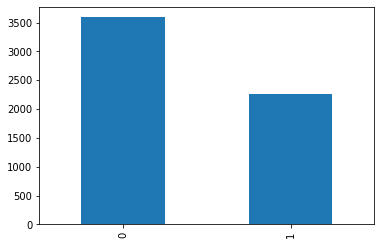

In [18]:
print(hasoc_data_df_task_a.label.value_counts())
hasoc_data_df_task_a.label.value_counts().plot(kind='bar')

### Split dataframe into train and validation

In [0]:
data_df = data_utils.Datasplitter.split_dataframe(hasoc_data_df_task_a, train_frac= 0.9, shuffle=True )

In [20]:
print(data_df.split.value_counts())
sum(data_df.label.value_counts()) == \
sum(data_df[data_df.split == 'train'].label.value_counts())\
 + sum(data_df[data_df.split == 'val'].label.value_counts())

train    5267
val       585
Name: split, dtype: int64


True

In [21]:
hasoc_data_df_task_a.label.value_counts()

0    3591
1    2261
Name: label, dtype: int64

## Create GPT2 Preprocessor
Add special tokens

In [0]:
class GPT2Preprocessor():
    """Adds special tokens to the samples"""
    def __init__(self,transformer_tokenizer,sentence_detector):
        self.transformer_tokenizer = transformer_tokenizer
        self.sentence_detector = sentence_detector
        
    def add_eos_tokens(self, text):
        eos_token = ' ' + self.transformer_tokenizer.eos_token + ' '
        sentences = self.sentence_detector.tokenize(text)
        eos_added_text  = eos_token.join(sentences) + ' ' + self.transformer_tokenizer.eos_token
        return eos_added_text 

In [23]:
try:
    punkt_sentence_detector = nltk.data.load('tokenizers/punkt/english.pickle')
except:
    nltk.download('punkt')
    punkt_sentence_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [24]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(
    'gpt2'
)

In [0]:
gpt2_preproc = GPT2Preprocessor(gpt2_tokenizer, punkt_sentence_detector)

In [26]:
data_df['text'] = data_df['text'].map(gpt2_preproc.add_eos_tokens)
print(data_df.columns)
print(data_df.label.value_counts())
print(data_df.split.value_counts())

Index(['text', 'label', 'split'], dtype='object')
0    3591
1    2261
Name: label, dtype: int64
train    5267
val       585
Name: split, dtype: int64


In [27]:
with pd.option_context('display.max_colwidth', -1): 
    print(data_df[:5])

                                                                                                                                                                                                                                                                                                    text  ...  split
1840  BBMCH Balangir stand with NRSMCH  #DoctorsFightBack   #NRSMedicalCollege https://t.co/jfVN3DSfFJ <|endoftext|>                                                                                                                                                                                      ...  train
1544  More evidence piles in. <|endoftext|> Happy #JohnMcCainDay #TrumpIsATraitor #TrumpCrimeFamily #Oreo #DitchMitch2020 #arrestBARR  #Vets https://t.co/1R3hhH3mxW <|endoftext|>                                                                                                                        ...  train
2101  'Dhoni will always be my Captain' - 7th time so far Kohli has said 

## Create the pytorch dataset

In [0]:
dataset = transformer_data_utils.HateDataset(
    data_df = data_df,
    tokenizer = gpt2_tokenizer,
    max_len = 512,
)

### Create the model

In [0]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(
        self,
        hidden_size: int,
        num_classes:int,
        max_seq_len:int,
        gpt_model_name:str,
    ):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(
            gpt_model_name,
        )
        self.fc1 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x_in):
        
        gpt_out = self.gpt2model(x_in)[0] #returns tuple
        batch_size = gpt_out.shape[0]
        prediction_vector = self.fc1(gpt_out.view(batch_size,-1)) #(batch_size , max_len, num_classes)
    
        return prediction_vector
        

In [30]:
num_classes = len(set(data_df.label))
hidden_size = min(dataset._max_seq_length,1024) * 768
model = SimpleGPT2SequenceClassifier(
    hidden_size=hidden_size, 
    num_classes = num_classes,
    gpt_model_name = 'gpt2',
    max_seq_len = dataset._max_seq_length,
)

## Training Routine

In [31]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model = model.to(args.device)


loss_func = nn.CrossEntropyLoss()
print(f'Using LR:{args.learning_rate}')
early_stopping = transformer_general_utils.EarlyStopping(patience=4)
optimizer = optim.AdamW(model.parameters(), lr = args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = 'min',
    factor =0.5,
    patience = 1,
)

Using LR:0.0001


In [32]:
train_state = general_utils.make_train_state() #dictionary for saving training routine information
train_state.keys()

dict_keys(['train_preds', 'train_indexes', 'train_targets', 'train_accuracies', 'train_f1s', 'train_losses', 'val_preds', 'val_indexes', 'val_targets', 'val_accuracies', 'val_f1s', 'val_losses', 'test_preds', 'test_indexes', 'test_targets', 'test_accuracies', 'test_f1s', 'test_losses', 'batch_preds', 'batch_targets', 'batch_indexes', 'epoch_index'])

In [33]:
!nvidia-smi

Sun Mar 29 09:25:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |   1373MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [34]:
if args.use_apex:
    print("Using Nvidia-Apex")
    opt_level = 'O1'
    model, optimizer = amp.initialize(model, optimizer, opt_level=opt_level)

Using Nvidia-Apex
Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [0]:
args.batch_size = 8 # depending on system

In [36]:
epoch_bar = notebook.tqdm(
    desc = 'training_routine',
    total = args.num_epochs,
    position=0,
    leave = True,
)
dataset.set_split('train')
train_bar = notebook.tqdm(
    desc = 'split=train ',
    total=dataset.get_num_batches(args.batch_size),
    position=0,
    leave=True,
)
dataset.set_split('val')
eval_bar = notebook.tqdm(
    desc = 'split=eval',
    total=dataset.get_num_batches(args.batch_size),
    position=0,
    leave=True,
)

for epoch_index in range(args.num_epochs):
    train_state['epoch_in'] = epoch_index

    dataset.set_split('train')
    batch_generator = transformer_data_utils.generate_batches(
        dataset= dataset, batch_size= args.batch_size, shuffle=True,
        device = args.device, drop_last=False,
        pinned_memory = False, n_workers = 2, 
    )

    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    model.train()

    train_bar.reset(
        total=dataset.get_num_batches(args.batch_size),
    )
    model.train()
    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        
        y_pred = model(
            batch_dict['x_data'],
        )
        y_pred = y_pred.view(-1, len(set(dataset.data_df.label)))
                             
        loss = loss_func(y_pred, batch_dict['y_target'])

        if args.use_apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
            
        optimizer.step()
                             
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)
                             
        y_pred = y_pred.detach().cpu()
        batch_dict['y_target'] = batch_dict['y_target'].cpu()
        
        acc_t = transformer_general_utils \
            .compute_accuracy(y_pred, batch_dict['y_target'])
        
        f1_t = transformer_general_utils \
            .compute_macro_f1(y_pred, batch_dict['y_target'], average='weighted')

        train_state['batch_preds'].append(y_pred)
        train_state['batch_targets'].append(batch_dict['y_target'])
        train_state['batch_indexes'].append(batch_dict['x_index'])

        running_acc += (acc_t - running_acc) / (batch_index + 1)
        running_f1 += (f1_t - running_f1) / (batch_index + 1)

        train_bar.set_postfix(loss = running_loss, f1 = running_f1, acc=running_acc,
                             epoch=epoch_index)

        train_bar.update()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    train_state['train_accuracies'].append(running_acc)
    train_state['train_losses'].append(running_loss)
    
    train_state['train_preds'].append(
        torch.cat(train_state['batch_preds']).cpu()
    )
    train_state['train_targets'].append(
        torch.cat(train_state['batch_targets']).cpu()
    )
    train_state['train_indexes'].append(
        torch.cat(train_state['batch_indexes']).cpu()
    )
    train_f1 = transformer_general_utils \
                .compute_macro_f1(train_state['train_preds'][-1],
                                  train_state['train_targets'][-1],
                                  'weighted'
                                 )
                                 
    train_state['train_f1s'].append(train_f1)
    
    train_state['batch_preds'] = []
    train_state['batch_targets'] = []
    train_state['batch_indexes'] = []
    
    
    dataset.set_split('val')
    batch_generator = transformer_data_utils.generate_batches(
        dataset= dataset, batch_size= args.batch_size, shuffle=True,
        device = args.device, drop_last=False,
        pinned_memory = True, n_workers = 2, 
    )
    eval_bar.reset(
        total=dataset.get_num_batches(args.batch_size),
    )
    running_loss = 0.0
    running_acc = 0.0
    running_f1 = 0.0
    
    model.eval()
    with torch.no_grad():
        # optimizer._backup_and_load_cache()
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = model(
                batch_dict['x_data'],
            )
            y_pred = y_pred.view(-1, len(set(dataset.data_df.label)))

            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            y_pred = y_pred.detach()
#             batch_dict['y_target'] = batch_dict['y_target'].cpu()
            
            acc_t = transformer_general_utils\
                .compute_accuracy(y_pred, batch_dict['y_target'])
            f1_t = transformer_general_utils \
                .compute_macro_f1(y_pred, batch_dict['y_target'],
                                 average='weighted')

            train_state['batch_preds'].append(y_pred.cpu())
            train_state['batch_targets'].append(batch_dict['y_target'])
            train_state['batch_indexes'].append(batch_dict['x_index'].cpu())

            running_acc += (acc_t - running_acc) / (batch_index + 1)
            running_f1 += (f1_t - running_f1) / (batch_index + 1)
            

            eval_bar.set_postfix(loss = running_loss, f1 = running_f1, acc=running_acc,
                                 epoch=epoch_index)
            eval_bar.update()
            
    train_state['val_accuracies'].append(running_acc)
    train_state['val_losses'].append(running_loss)
    
        
    train_state['val_preds'].append(
        torch.cat(train_state['batch_preds']).cpu()
    )

    train_state['val_targets'].append(
        torch.cat(train_state['batch_targets']).cpu()
    )
    train_state['val_indexes'].append(
        torch.cat(train_state['batch_indexes']).cpu()
    )
    val_f1 = transformer_general_utils \
                .compute_macro_f1(train_state['val_preds'][-1],
                                  train_state['val_targets'][-1],
                                  average='weighted',
                                 )
                                 
    train_state['val_f1s'].append(val_f1)
    
    train_state['batch_preds'] = []
    train_state['batch_targets'] = []
    train_state['batch_indexes'] = []
    
    torch.save(
        {
            'model':model.state_dict(),
        },
        args.directory + f'_epoc_{epoch_index}_' + args.model_name,
    )
    
    scheduler.step(val_f1)
    early_stopping(val_f1, model)
    # optimizer._clear_and_load_backup()
    epoch_bar.set_postfix( best_f1 = early_stopping.best_score, current = val_f1)
    epoch_bar.update()    
    
    if early_stopping.early_stop:
            print("Early stopping")
            break
    epoch_bar.set_postfix( best_f1 = early_stopping.best_score, current = val_f1 )
    epoch_bar.update()

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 256.0
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
